# Multi-Controller Comparison

Extended version of `three_controller_comparison.ipynb` that runs the offline optimum alongside:

- three constant-gain linear controllers with gains K = 0.53, 0.40, and 0.60
- two EGPC variants with different learning rates

All controllers share the same arrival sequence, so the resulting plots directly highlight behavioral differences across algorithms.


In [15]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
# Locate repo root so imports from src work even if notebook moves
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError("Could not locate 'src' directory relative to this notebook")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [16]:
import numpy as np

from src.offline_opt import solve_optimal_w
from src.simulate_storage_dynamics import simulate_storage_dynamics
from src.egpc import run_egpc
from src.plots import compare_controllers


In [17]:
# Simulation configuration
T = 1000            # horizon length
H = 100             # feature dimension for w* and EGPC
kappa = 0.4       # decay parameter for feature construction
linear_gains = [0.53, 0.20]

a_mode = 'arrivals_sinusoidal_rand'
cost_key = 'sin_randomized'

L_u = 2.6           # Lipschitz surrogate constant for u
L_b = 5.0           # Lipschitz surrogate constant for b
b0 = 0.0            # initial backlog for manual simulations

L = L_u + L_b
eta_tuned = np.sqrt(np.log(H) / T) / L
eta_theory = np.sqrt(np.log(H) / T/(1/2 + 1/(kappa**2))) / L
egpc_step_scales = [
    (f"EGPC [η∗]", eta_theory),
    ("EGPC [ηind] ", eta_tuned),
]


egpc_step_sizes = []
for label, step in egpc_step_scales:
    eta_val = step
    egpc_step_sizes.append((label, eta_val))
    print(f' - {label}: eta={eta_val:.4f}')


 - EGPC [η∗]: eta=0.0034
 - EGPC [ηind] : eta=0.0089


In [18]:
def simulate_constant_gain(K, arrivals, cost_fn, *, b0=0.0, cost_kwargs=None):
    """Simulate u_t = K * b_t with backlog recursion b_{t+1} = b_t - u_t + a_t."""
    K_clipped = float(np.clip(K, 0.0, 1.0))
    T = len(arrivals)
    cost_kwargs = {} if cost_kwargs is None else dict(cost_kwargs)
    b_levels = np.empty(T)
    u_actions = np.empty(T)
    costs = np.empty(T)
    b_t = float(b0)
    for t in range(T):
        b_levels[t] = b_t
        u_t = K_clipped * b_t
        u_actions[t] = u_t
        costs[t] = cost_fn(b_t, u_t, t + 1, **cost_kwargs)
        b_t = b_t - u_t + arrivals[t]
    return {'b': b_levels, 'u': u_actions, 'c': costs}


In [19]:
# Offline optimal controller w*
opt_result = solve_optimal_w(
    a_mode=a_mode,
    cost_key=cost_key,
    T=T,
    H=H,
    kappa=kappa,
    verbose=False,
)

a = opt_result['a']
cost_fn = opt_result['cost_fn']
cost_kwargs = opt_result.get('cost_kwargs', {})
Phi = opt_result['Phi']
Psi = opt_result['Psi']
w_star = opt_result['w_star']

opt_sim = simulate_storage_dynamics(
    Phi,
    Psi,
    a,
    w_star,
    cost_fn=cost_fn,
    cost_kwargs=cost_kwargs,
)
print(f"Offline optimal total cost: {opt_sim['total_cost']:.4f}")



──────────────────────────────
Optimal weight vector found for 'arrivals_sinusoidal_rand' | cost='sin_randomized'
Objective value: 963.8733
w* (rounded): [0.4042 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0033 0.0072 0.0053 0.0092
 0.0091 0.0082 0.0073 0.007  0.0069 0.0071 0.0073 0.0075 0.0077 0.0079
 0.008  0.0081 0.0081 0.0082 0.0082 0.0082 0.0082 0.0082 0.0083 0.0083
 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083
 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083
 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083
 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083
 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083 0.0083]
Sum(w*): 1.0000
──────────────────────────────
Offline optimal total cost: 963.8733


In [20]:
# Constant-gain linear controllers
linear_entries = []
for K in linear_gains:
    sim = simulate_constant_gain(
        K,
        a,
        cost_fn,
        b0=b0,
        cost_kwargs=cost_kwargs,
    )
    label = f'Linear K={K:.2f}'
    linear_entries.append((label, sim))
    print(f"{label}: total cost {float(np.sum(sim['c'])):.4f}")


Linear K=0.53: total cost 984.5877
Linear K=0.20: total cost 2671.6528


In [21]:
# EGPC controllers with different step sizes

def replay_arrivals(T_requested, amplitude=1.0, **kwargs):
    if T_requested != len(a):
        raise ValueError(f'Expected horizon {len(a)}, received {T_requested}.')
    return a.copy()

egpc_entries = []
for base_label, eta_val in egpc_step_sizes:
    label = f"{base_label} (eta={eta_val:.4f})"
    result = run_egpc(
        a_fn=replay_arrivals,
        cost_fn=cost_fn,
        cost_kwargs=cost_kwargs,
        eta=eta_val,
        H=H,
        T=T,
        kappa=kappa,
    )
    egpc_entries.append((label, result))
    print(f"{label}: total cost {result['total_cost']:.4f}")


EGPC [η∗] (eta=0.0034): total cost 1043.3331
EGPC [ηind]  (eta=0.0089): total cost 1023.4862


# linear

In [22]:
# Aggregate controller outputs for downstream comparisons
controller_entries_linear = [("Offline Opt", opt_sim)]
controller_entries_linear.extend(linear_entries)
print('Controllers prepared:', [name for name, _ in controller_entries_linear])


Controllers prepared: ['Offline Opt', 'Linear K=0.53', 'Linear K=0.20']


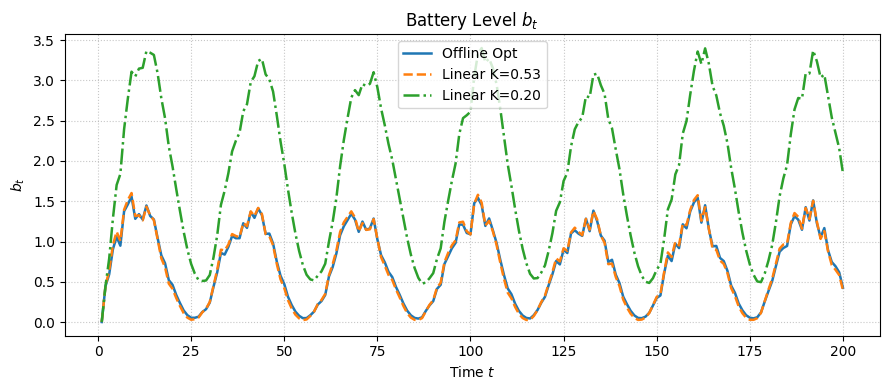

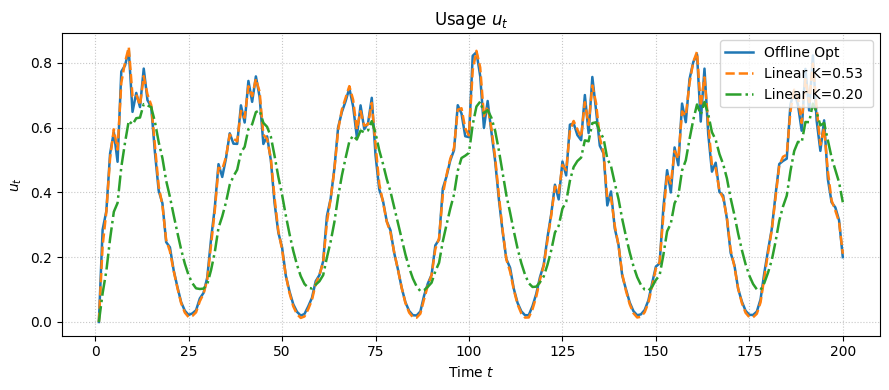

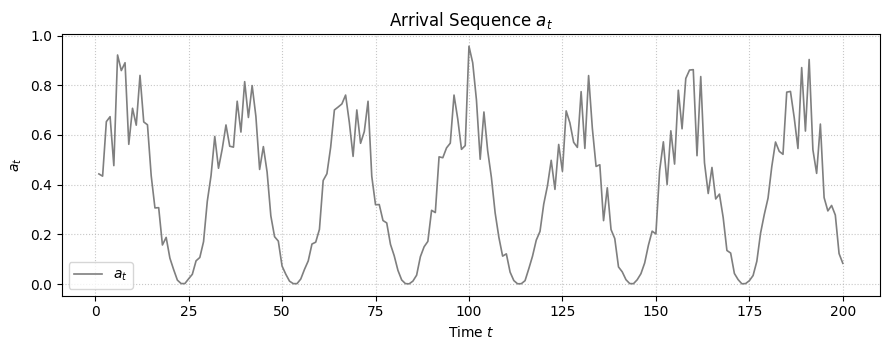

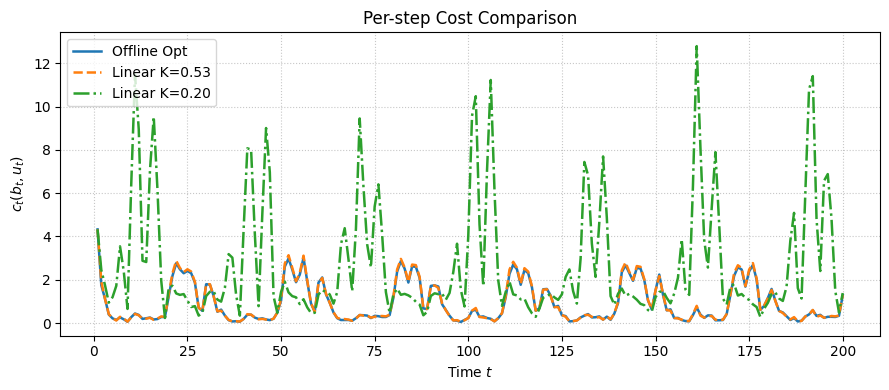


──────────────────────────────
Offline Opt     Total cost: 963.8733
Linear K=0.53   Total cost: 984.5877
Linear K=0.20   Total cost: 2671.6528
──────────────────────────────


{'total_costs': {'Offline Opt': 963.8733114988124,
  'Linear K=0.53': 984.5877272531968,
  'Linear K=0.20': 2671.6528021852964},
 'pairwise_abs_diff': {'Offline Opt vs Linear K=0.53': {'b_diff': 0.025087417782510658,
   'u_diff': 0.01189016295036231,
   'cost_diff': 0.03342166604322305},
  'Offline Opt vs Linear K=0.20': {'b_diff': 1.1628105203992474,
   'u_diff': 0.1120692131556957,
   'cost_diff': 2.3654350718262394},
  'Linear K=0.53 vs Linear K=0.20': {'b_diff': 1.164395571542898,
   'u_diff': 0.1117287039075723,
   'cost_diff': 2.377277536526784}},
 'total_cost_1': 963.8733114988124,
 'total_cost_2': 984.5877272531968,
 'b_diff': 0.025087417782510658,
 'u_diff': 0.01189016295036231,
 'cost_diff': 0.03342166604322305,
 'plot_window': {'start': 0, 'end': 200}}

In [23]:
plot_horizon = 200
plot_start = 0

comparison_metrics = compare_controllers(
    controller_entries_linear,
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


# egpc


In [24]:
# Aggregate controller outputs for downstream comparisons
controller_entries_egpc = [("Offline Opt", opt_sim)]
controller_entries_egpc.extend(egpc_entries)
print('Controllers prepared:', [name for name, _ in controller_entries_egpc])


Controllers prepared: ['Offline Opt', 'EGPC [η∗] (eta=0.0034)', 'EGPC [ηind]  (eta=0.0089)']


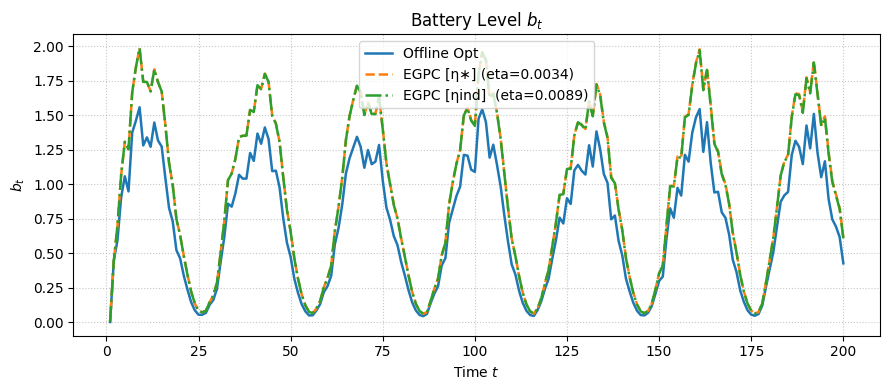

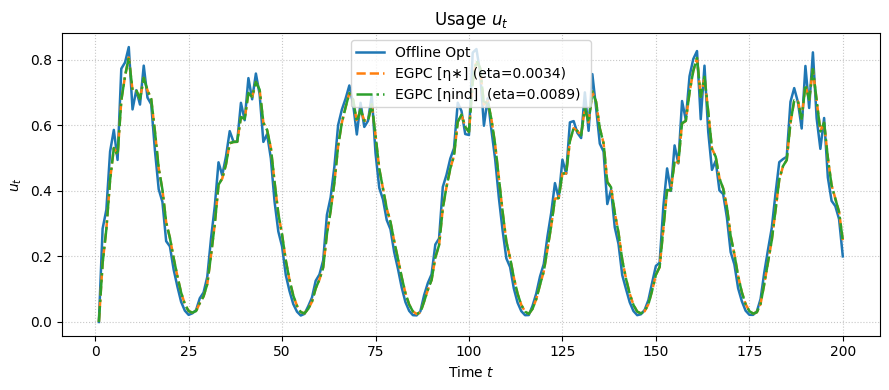

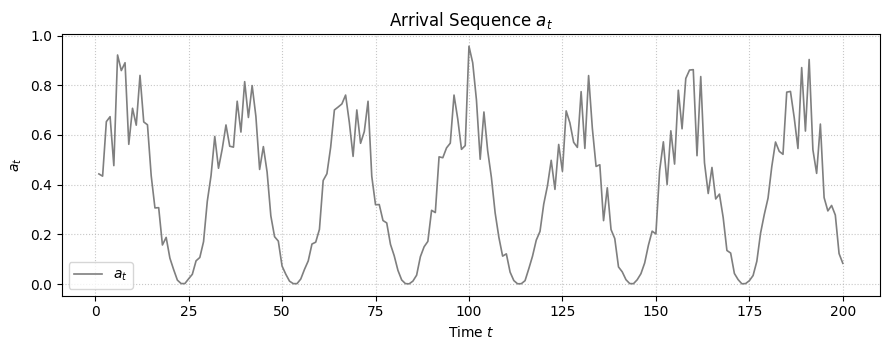

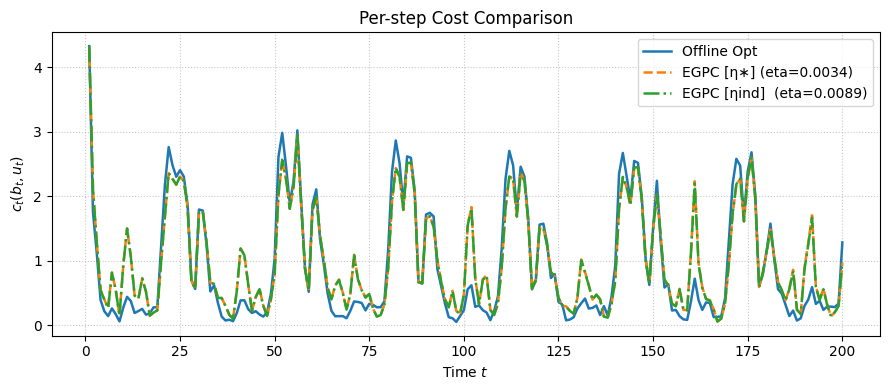


──────────────────────────────
Offline Opt     Total cost: 963.8733
EGPC [η∗] (eta=0.0034) Total cost: 1043.3331
EGPC [ηind]  (eta=0.0089) Total cost: 1023.4862
──────────────────────────────


{'total_costs': {'Offline Opt': 963.8733114988124,
  'EGPC [η∗] (eta=0.0034)': 1043.3331469372456,
  'EGPC [ηind]  (eta=0.0089)': 1023.4861806261155},
 'pairwise_abs_diff': {'Offline Opt vs EGPC [η∗] (eta=0.0034)': {'b_diff': 0.21616213062184259,
   'u_diff': 0.031695385200674664,
   'cost_diff': 0.22055352454426946},
  'Offline Opt vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.2135303222420553,
   'u_diff': 0.031374425635105625,
   'cost_diff': 0.21706884631638024},
  'EGPC [η∗] (eta=0.0034) vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.002631808379787287,
   'u_diff': 0.00035231411861446087,
   'cost_diff': 0.003568935358333297}},
 'total_cost_1': 963.8733114988124,
 'total_cost_2': 1043.3331469372456,
 'b_diff': 0.21616213062184259,
 'u_diff': 0.031695385200674664,
 'cost_diff': 0.22055352454426946,
 'plot_window': {'start': 0, 'end': 200}}

In [25]:
plot_horizon = 200
plot_start = 0

comparison_metrics = compare_controllers(
    controller_entries_egpc,
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


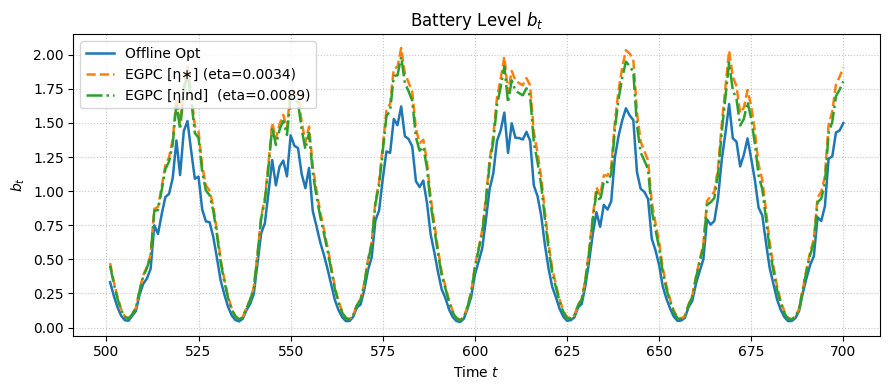

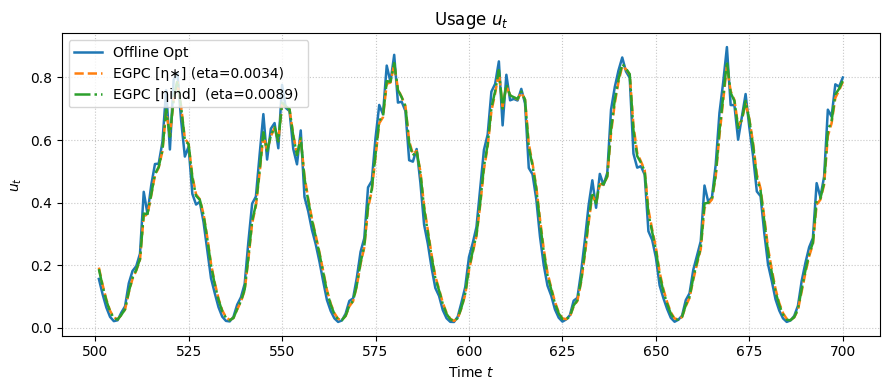

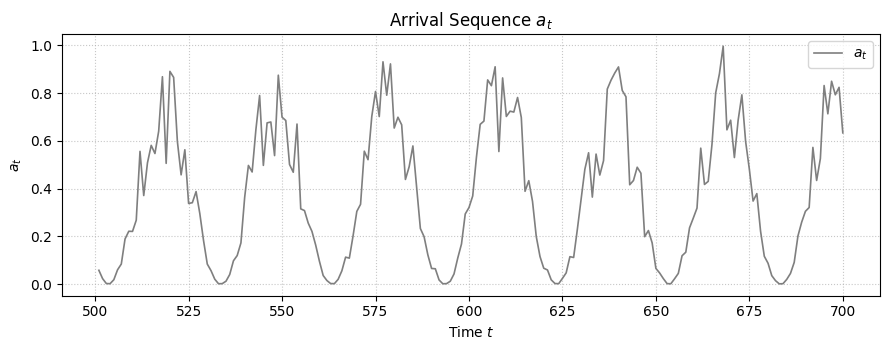

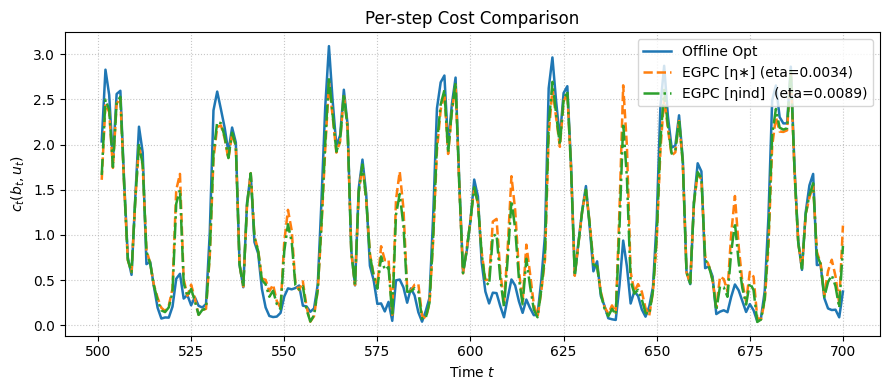


──────────────────────────────
Offline Opt     Total cost: 963.8733
EGPC [η∗] (eta=0.0034) Total cost: 1043.3331
EGPC [ηind]  (eta=0.0089) Total cost: 1023.4862
──────────────────────────────


{'total_costs': {'Offline Opt': 963.8733114988124,
  'EGPC [η∗] (eta=0.0034)': 1043.3331469372456,
  'EGPC [ηind]  (eta=0.0089)': 1023.4861806261155},
 'pairwise_abs_diff': {'Offline Opt vs EGPC [η∗] (eta=0.0034)': {'b_diff': 0.20144998093005032,
   'u_diff': 0.030457468948483446,
   'cost_diff': 0.2263308600589643},
  'Offline Opt vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.1651590017078235,
   'u_diff': 0.025360262114879798,
   'cost_diff': 0.17682332781972057},
  'EGPC [η∗] (eta=0.0034) vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.03629097922222685,
   'u_diff': 0.005189931750472109,
   'cost_diff': 0.05073200691446307}},
 'total_cost_1': 963.8733114988124,
 'total_cost_2': 1043.3331469372456,
 'b_diff': 0.20144998093005032,
 'u_diff': 0.030457468948483446,
 'cost_diff': 0.2263308600589643,
 'plot_window': {'start': 500, 'end': 700}}

In [26]:
plot_horizon = 200
plot_start = 500

comparison_metrics = compare_controllers(
    controller_entries_egpc,
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


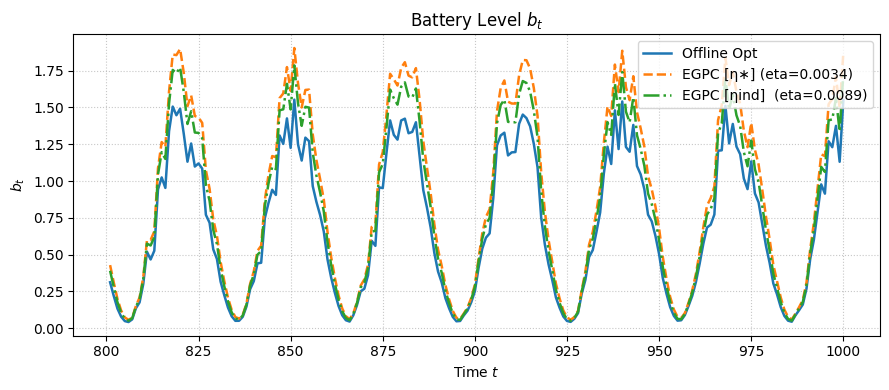

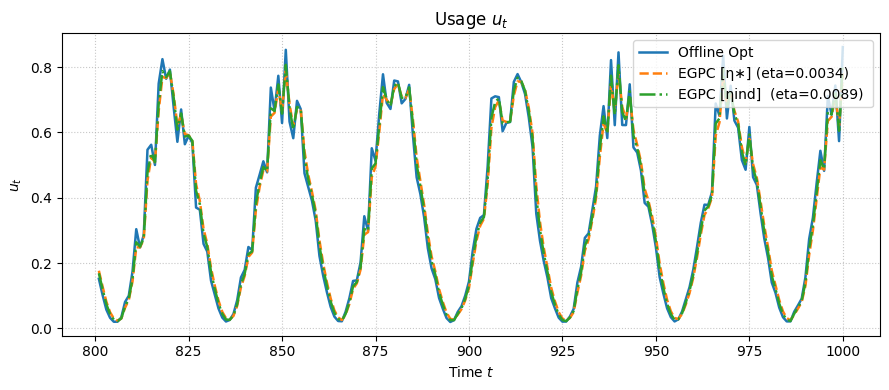

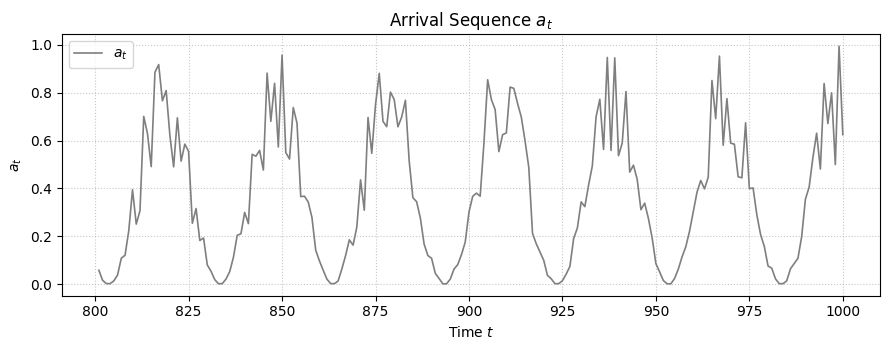

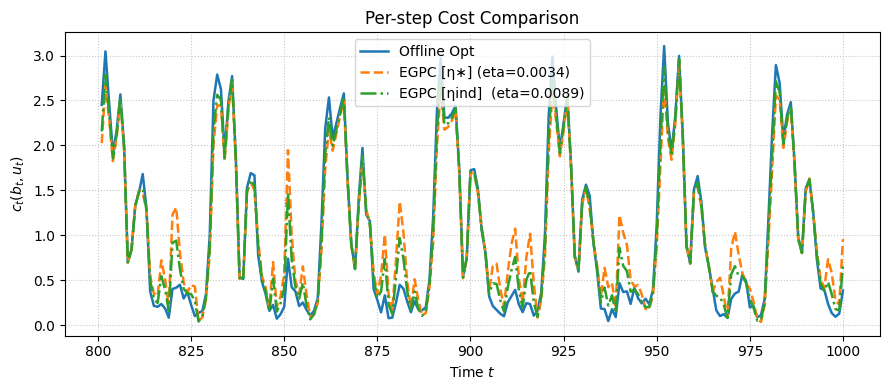


──────────────────────────────
Offline Opt     Total cost: 963.8733
EGPC [η∗] (eta=0.0034) Total cost: 1043.3331
EGPC [ηind]  (eta=0.0089) Total cost: 1023.4862
──────────────────────────────


{'total_costs': {'Offline Opt': 963.8733114988124,
  'EGPC [η∗] (eta=0.0034)': 1043.3331469372456,
  'EGPC [ηind]  (eta=0.0089)': 1023.4861806261155},
 'pairwise_abs_diff': {'Offline Opt vs EGPC [η∗] (eta=0.0034)': {'b_diff': 0.18973664653248995,
   'u_diff': 0.0294944548736077,
   'cost_diff': 0.1985281680812433},
  'Offline Opt vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.11709102008590276,
   'u_diff': 0.018960209911995415,
   'cost_diff': 0.11134310022915696},
  'EGPC [η∗] (eta=0.0034) vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.07264562644658717,
   'u_diff': 0.010680053569263579,
   'cost_diff': 0.0888048923530922}},
 'total_cost_1': 963.8733114988124,
 'total_cost_2': 1043.3331469372456,
 'b_diff': 0.18973664653248995,
 'u_diff': 0.0294944548736077,
 'cost_diff': 0.1985281680812433,
 'plot_window': {'start': 800, 'end': 1000}}

In [27]:
plot_horizon = 200
plot_start = 800

comparison_metrics = compare_controllers(
    controller_entries_egpc,
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


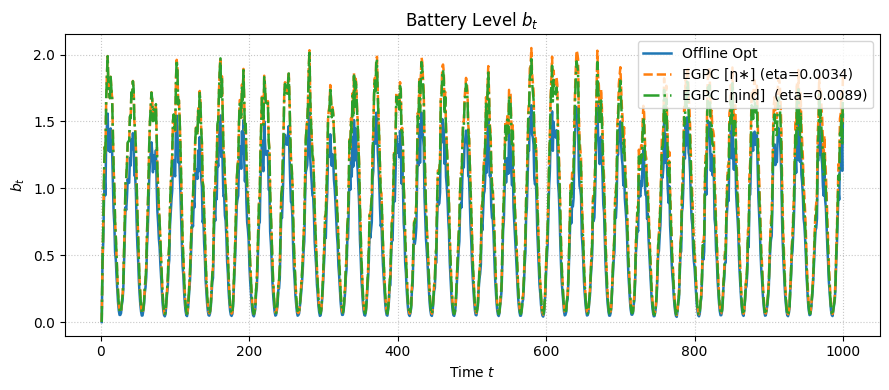

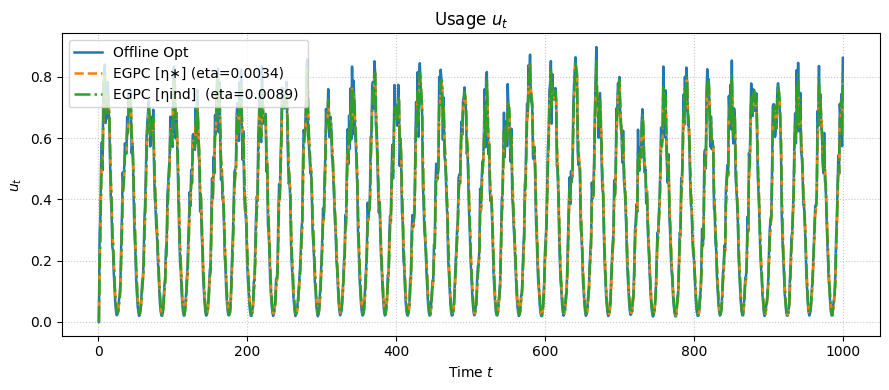

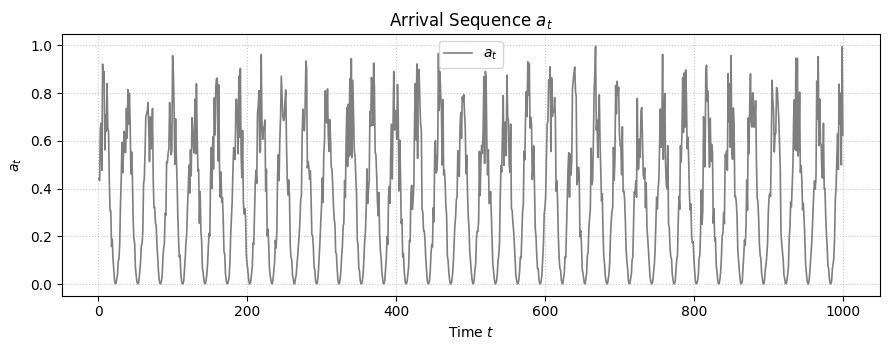

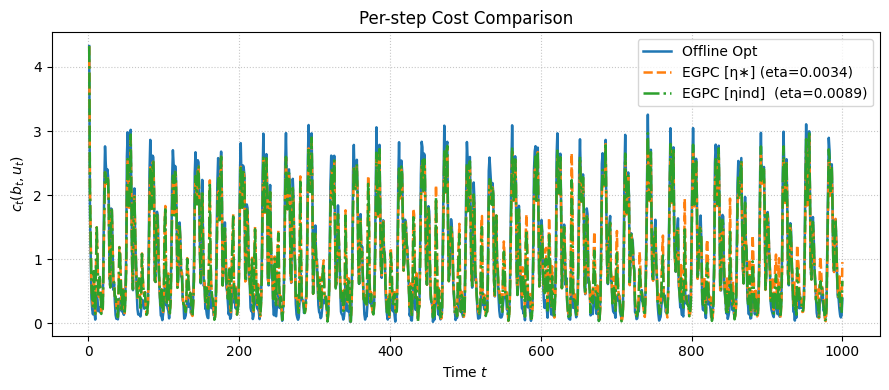


──────────────────────────────
Offline Opt     Total cost: 963.8733
EGPC [η∗] (eta=0.0034) Total cost: 1043.3331
EGPC [ηind]  (eta=0.0089) Total cost: 1023.4862
──────────────────────────────


{'total_costs': {'Offline Opt': 963.8733114988124,
  'EGPC [η∗] (eta=0.0034)': 1043.3331469372456,
  'EGPC [ηind]  (eta=0.0089)': 1023.4861806261155},
 'pairwise_abs_diff': {'Offline Opt vs EGPC [η∗] (eta=0.0034)': {'b_diff': 0.20342100800645843,
   'u_diff': 0.0302743792828957,
   'cost_diff': 0.2135804902212134},
  'Offline Opt vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.17128260688132743,
   'u_diff': 0.02581285409884147,
   'cost_diff': 0.1738717834870592},
  'EGPC [η∗] (eta=0.0034) vs EGPC [ηind]  (eta=0.0089)': {'b_diff': 0.03213840112513101,
   'u_diff': 0.004552339714692993,
   'cost_diff': 0.04059107421424129}},
 'total_cost_1': 963.8733114988124,
 'total_cost_2': 1043.3331469372456,
 'b_diff': 0.20342100800645843,
 'u_diff': 0.0302743792828957,
 'cost_diff': 0.2135804902212134,
 'plot_window': {'start': 0, 'end': 1000}}

In [28]:
plot_horizon = 1000
plot_start = 0

comparison_metrics = compare_controllers(
    controller_entries_egpc,
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


In [ ]:
"""
geometry.py

A simple utility module for geometric calculations.
This module currently supports calculating the area of a circle.
"""

import math
from typing import Union

# Define a custom type alias for clarity (optional, but good for readability)
Number = Union[int, float]

def calculate_circle_area(radius: Number) -> float:
    """
    Calculates the area of a circle given its radius.

    Args:
        radius (int or float): The radius of the circle. Must be non-negative.

    Returns:
        float: The area of the circle (πr²).

    Raises:
        TypeError: If the radius is not a number.
        ValueError: If the radius is negative.
    """
    # 1. Validate Type
    if not isinstance(radius, (int, float)):
        raise TypeError(f"Radius must be a number, got {type(radius).__name__}")

    # 2. Validate Value (The ValueError example)
    if radius < 0:
        raise ValueError(f"Radius cannot be negative. Received: {radius}")

    # 3. Perform Calculation
    return math.pi * (radius ** 2)


# --- Module Execution Block ---
# This block only runs if you run this file directly (e.g., `python geometry.py`)
if __name__ == "__main__":
    print("--- Running Geometry Module Test ---")

    # Test Case 1: Valid Input
    try:
        r = 5
        area = calculate_circle_area(r)
        print(f"Area of circle with radius {r}: {area:.2f}")
    except Exception as e:
        print(f"Test 1 Failed: {e}")

    # Test Case 2: Invalid Value (Demonstrating ValueError)
    try:
        print("\nAttempting to calculate area for radius -10...")
        calculate_circle_area(-10)
    except ValueError as e:
        print(f"Caught expected error: {e}")
    except Exception as e:
        print(f"Caught unexpected error: {type(e).__name__}")